In [37]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

In [38]:
# Parameters
N = 5  # number of vertices on the cycle
tau_values = { '0': 0, '1': 2 }  # liveliness parameters for binary bits (example)
coin_dim = 3

# Initial state: position and coin state (uniform superposition over coin states)
pos0 = 0
coin0 = (1/np.sqrt(3)) * (qt.basis(coin_dim, 0) + qt.basis(coin_dim, 1) + qt.basis(coin_dim, 2))
psi0 = qt.tensor(qt.basis(N, pos0), coin0)

def shift_operator(N, tau):
    S = sum(
        qt.tensor(qt.basis(N, (x+1)%N)*qt.basis(N, x).dag(), qt.basis(coin_dim, 0)*qt.basis(coin_dim,0).dag()) +
        qt.tensor(qt.basis(N, (x-1)%N)*qt.basis(N, x).dag(), qt.basis(coin_dim, 1)*qt.basis(coin_dim,1).dag()) +
        qt.tensor(qt.basis(N, (x+tau)%N)*qt.basis(N, x).dag(), qt.basis(coin_dim, 2)*qt.basis(coin_dim,2).dag())
        for x in range(N)
    )
    return S

G = (2/3)*np.ones((coin_dim, coin_dim)) - np.eye(coin_dim)
coin_operator = qt.tensor(qt.qeye(N), qt.Qobj(G))

def evolution_operator(N, bit, tau_values):
    tau = tau_values[bit]
    return shift_operator(N, tau) * coin_operator

def controlled_quantum_walk_hash(msg, N, psi0, tau_values):
    psi = psi0
    for bit in msg:
        U = evolution_operator(N, bit, tau_values)
        psi = U * psi
    return psi

def generate_hash(psi_final, N, s=8, l=10):
    prob_dist = np.abs(psi_final.full())**2
    prob_pos = np.sum(prob_dist.reshape(N, coin_dim), axis=1).flatten()
    hash_bits = ''
    for p in prob_pos:
        scaled_p = int((p * 10**l) % (2**s))
        hash_bits += format(scaled_p, '0' + str(s) + 'b')
    return hash_bits

# Example message
message = "{0:b}".format(5)

# Initial state defined previously (psi0)
psi_final = controlled_quantum_walk_hash(message, N, psi0, tau_values)

# Generate hash value (with parameters s=8, l=10 as an example)
hash_value = generate_hash(psi_final, N, s=8, l=10)

#print("Hash value:", hash_value)
print("Int:", int(hash_value, 2))

message = "{0:b}".format(6)

# Initial state defined previously (psi0)
psi_final = controlled_quantum_walk_hash(message, N, psi0, tau_values)

# Generate hash value (with parameters s=8, l=10 as an example)
hash_value = generate_hash(psi_final, N, s=8, l=10)

#print("Hash value:", hash_value)
print("Int:", int(hash_value, 2))

Int: 758873889434
Int: 78790665252


Int: 0
Int: 1005025
Int: 2010050
Int: 3015075
Int: 4020100
Int: 5025125
Int: 6030150
Int: 7035175
Int: 8040201
Int: 9045226
Int: 10050251
Int: 11055276
Int: 12060301
Int: 13065326
Int: 14070351
Int: 15075376
Int: 16080402
Int: 17085427
Int: 18090452
Int: 19095477
Int: 20100502
Int: 21105527
Int: 22110552
Int: 23115577
Int: 24120603
Int: 25125628
Int: 26130653
Int: 27135678
Int: 28140703
Int: 29145728
Int: 30150753
Int: 31155778
Int: 32160804
Int: 33165829
Int: 34170854
Int: 35175879
Int: 36180904
Int: 37185929
Int: 38190954
Int: 39195979
Int: 40201005
Int: 41206030
Int: 42211055
Int: 43216080
Int: 44221105
Int: 45226130
Int: 46231155
Int: 47236180
Int: 48241206
Int: 49246231
Int: 50251256
Int: 51256281
Int: 52261306
Int: 53266331
Int: 54271356
Int: 55276381
Int: 56281407
Int: 57286432
Int: 58291457
Int: 59296482
Int: 60301507
Int: 61306532
Int: 62311557
Int: 63316582
Int: 64321608
Int: 65326633
Int: 66331658
Int: 67336683
Int: 68341708
Int: 69346733
Int: 70351758
Int: 71356783
Int: 723

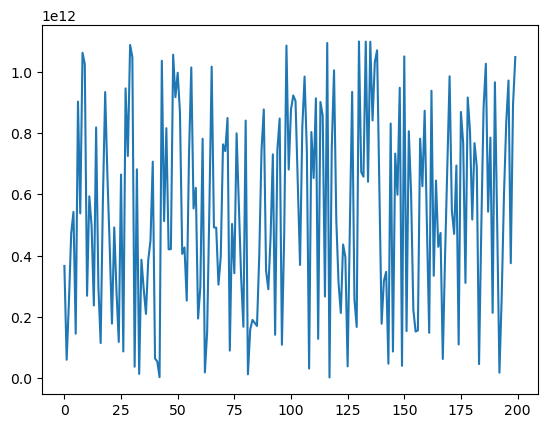

In [39]:
indices = np.linspace(0, 2e8, 200)
list = []

for i in indices:
    i = int(i)
    message = "{0:b}".format(i)
    psi_final = controlled_quantum_walk_hash(message, N, psi0, tau_values)
    hash_value = generate_hash(psi_final, N, s=8, l=10)
    list.append(int(hash_value, 2))
    print("Int:", i)

plt.plot(list)

In [ ]:

# Use previous definitions of shift_operator, coin_operator, evolution_operator, controlled_quantum_walk_hash, generate_hash

# Collision test function
def collision_test(msg_length=20, num_tests=1000, s=8, l=10):
    collisions = 0
    hash_dict = {}
    messages = set()

    while len(messages) < num_tests:
        msg = ''.join(np.random.choice(['0', '1']) for _ in range(msg_length))
        if msg not in messages:
            messages.add(msg)
            psi_final = controlled_quantum_walk_hash(msg, N, psi0, tau_values)
            hash_val = generate_hash(psi_final, N, s, l)

            if hash_val in hash_dict:
                collisions += 1
            else:
                hash_dict[hash_val] = msg
        print(f"Message: {len(msg)}, Hash: {len(hash_val)}")

    collision_rate = collisions / num_tests
    print(f'Total tests: {num_tests}')
    print(f'Collisions detected: {collisions}')
    print(f'Collision rate: {collision_rate:.4f}')


# Run collision test
collision_test(msg_length=20, num_tests=1000, s=8, l=10)


Total tests: 1000
Collisions detected: 0
Collision rate: 0.0000


In [36]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer

# Parameters
n_qubits_pos = 6  # Number of qubits for position (e.g., 2^6 = 64 positions)
n_qubits_coin = 2  # Coin qubits (2 qubits sufficient for 3 coin states)
n_qubits_msg = 1   # Message qubit (1 qubit for each bit)

# Circuit setup
qc = QuantumCircuit(n_qubits_pos + n_qubits_coin + n_qubits_msg, name='CAQW')

# Registers
pos = list(range(n_qubits_pos))
coin = list(range(n_qubits_pos, n_qubits_pos + n_qubits_coin))
msg = n_qubits_pos + n_qubits_coin

# Example message bits
message = "101"

# Initialization (superposition of coin states)
qc.h(coin)

# Quantum walk steps based on message bits
for idx, bit in enumerate(message):
    # Encode message bit
    if bit == '1':
        qc.x(msg)

    # Coin operation (simplified Grover coin)
    qc.h(coin)
    qc.x(coin)
    qc.h(coin[1])
    qc.cx(coin[0], coin[1])
    qc.h(coin[1])
    qc.x(coin)
    qc.h(coin)

    # Controlled shift operation (simplified example)
    for i in pos:
        qc.cx(coin[0], i)
        qc.cx(coin[1], i)

    # Reset message bit for next round
    if bit == '1':
        qc.x(msg)

qc.barrier()

# Measurement (optional, showing final probabilities)
qc.measure_all()

# Draw circuit
qc.draw(output='mpl', style='iqx', scale=0.7, fold=30, filename='CAQW_circuit.png')


TypeError: 'list' object is not callable